# Hyperellipsoid Density Sampling
- Generates non-uniform sample sequence.
- Improves solution quality in high-dimensional evolutionary optimization when used as the initialization method (compared to uniform QMC sampling).

## Sampling Algorithm

Calculating ellipsoid density.
Orienting axes.
Geometric void filling 23444 samples.


python(74462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



results:
    - number of samples: 100000
    - sample generation time: 22.29
    - number of hyperellipsoids: 17
    - number of initial QMC: 32768
    - number of initial clusters: 25
    - gaussian weights: {0: {'center': 0.25, 'std': 0.33}, 1: {'center': 0.25, 'std': 0.33}}

stats:
    - mean HDS: 0.50
    - mean comparison QMC: 0.50
    - stdev HDS: 0.19
    - stdev comparison QMC: 0.29



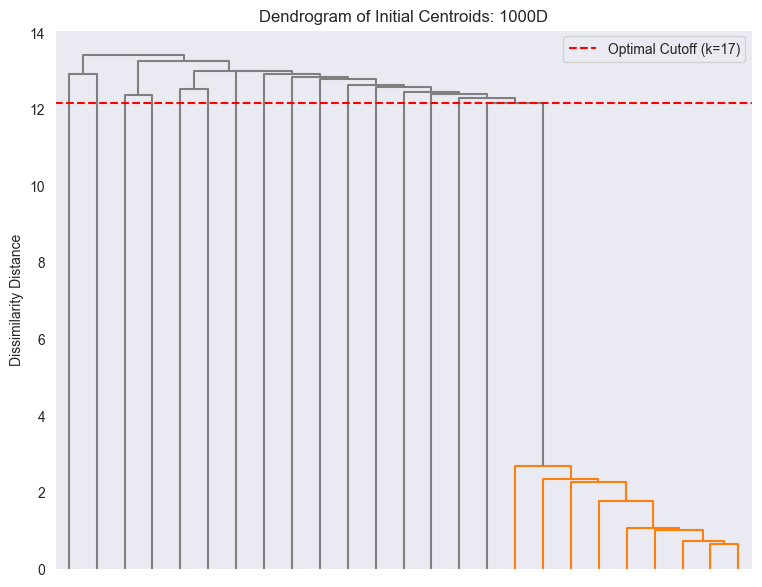

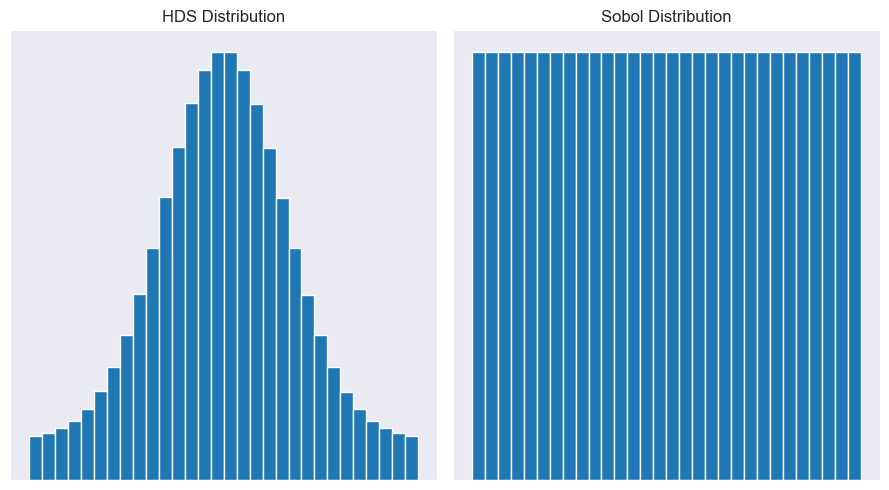

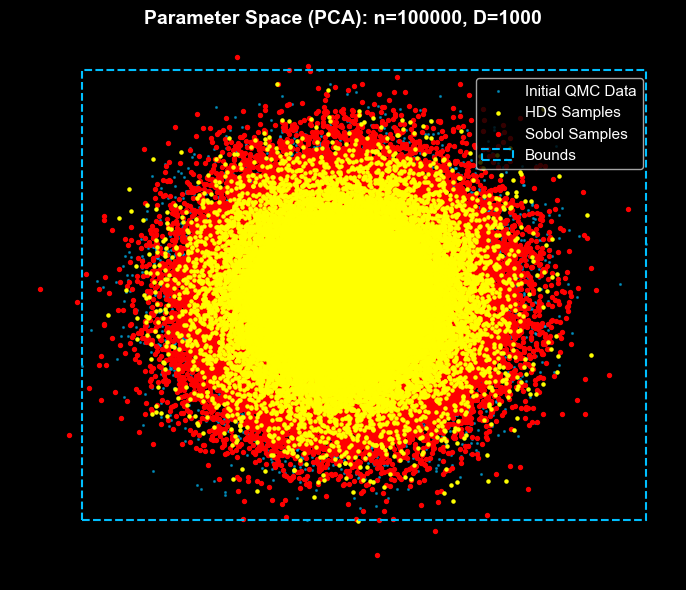

min: 0.00, max: 1.00


In [2]:
# global epslion
epsilon = 1e-12

### misc helper functions 

def sample_hypersphere(n_dimensions, radius, n_samples_in_sphere, radius_qmc_sequence):
    '''
    Objective:
        - Samples unit hyperspheres using Marsaglia polar vectors scaled by a QMC sequence.
    '''
    import numpy as np
    
    # generate normal distribution (for angular direction)
    samples = np.random.normal(size=(n_samples_in_sphere, n_dimensions))
    
    # normalize vectors to get points on the surface of a unit sphere (direction)
    squared_norms = np.sum(samples**2, axis=1)
    inv_norms = 1.0 / (np.sqrt(squared_norms) + epsilon)
    
    # efficiently apply directions (broadcasting faster than division)
    samples = samples * inv_norms[:, np.newaxis]
    
    # use input QMC sequence for radius scaling (r^(1/n))
    random_radii_qmc = np.power(radius_qmc_sequence, (1.0 / n_dimensions))
    
    # scale and apply final radius
    samples = samples * (random_radii_qmc * radius)[:, np.newaxis]
    
    return samples

def sample_hyperellipsoid(n_dimensions, n_samples_in_ellipsoid, origin, pca_components, pca_variances, scaling_factor, radius_qmc_sequence=None):
    '''
    Objective:
        - Generates samples inside the hyperellipsoid.
            - Calls the function to sample unit hyperspheres.
            - Transforms the hyperspherical samples to the ellipsoid axes defined using the PCA variances.
    '''
    import numpy as np
    
    # generate samples in unit hypersphere
    unit_sphere_samples = sample_hypersphere(n_dimensions, 1.0, n_samples_in_ellipsoid, radius_qmc_sequence)
    
    # axis lengths: L = sqrt(variance + epsilon) * scaling_factor
    axis_lengths = np.sqrt(pca_variances + epsilon) * scaling_factor
    
    # scale samples in PCA space and rotates back to original parameter space
    scaled_and_rotated = (unit_sphere_samples * axis_lengths) @ pca_components
    
    # translate samples to cluster origin
    ellipsoid_samples = scaled_and_rotated + origin
    
    return ellipsoid_samples

def sample_in_voids(existing_samples, n_to_fill, bounds_min, bounds_max,
                    k_neighbors=5, spread_factor=0.5,
                    n_query_max=1000, n_tree_max=10000): 
    '''
    Objective:
        - Identify & fill voids in the sample space, using the out-of-bounds sample set.
        - Uses BallTree K-NearestNeighbors to identify voids.
    '''
    from sklearn.neighbors import BallTree
    from sklearn.random_projection import GaussianRandomProjection
    import numpy as np
    from scipy import stats
    import time
    
    # extract shape
    n_existing, n_dimensions = existing_samples.shape

    # if no samples to replace
    if n_to_fill <= 0:
        return np.zeros((0, n_dimensions))
        
    # if number of neighbors exceeds number of existing samples
    if n_existing < k_neighbors + 1:
        return stats.uniform.rvs(loc=bounds_min, scale=bounds_max - bounds_min, size=(n_to_fill, n_dimensions))

    # for number of points > 100,000, reduce size to 10,000 for speed
    if n_existing > n_tree_max:
        tree_indices = np.random.choice(n_existing, size=n_tree_max, replace=False)
        tree_samples = existing_samples[tree_indices]
    else:
        tree_indices = np.arange(n_existing)
        tree_samples = existing_samples
        
    # recalculate n_existing for reduced set
    n_existing_for_tree = tree_samples.shape[0]

    # reduce dimensionality for speed
    n_rp_components = min(max(10, int(2*np.log2(n_dimensions))), n_dimensions)
    if n_rp_components < n_dimensions:
        rp = GaussianRandomProjection(n_components=n_rp_components)
        existing_samples_reduced = rp.fit_transform(tree_samples)
    else:
        existing_samples_reduced = tree_samples
    
    # build BallTree
    start_kdtree_build = time.time()
    tree = BallTree(existing_samples_reduced) 
    
    # BallTree query on subset
    k_to_query = k_neighbors + 1 # k-th neighbor distance

    # select random subset of centers to calculate void probability for (query set)
    # query set sampled from the reduced set (existing_samples_reduced)
    if n_existing_for_tree > n_query_max:
        query_subset_indices = np.random.choice(n_existing_for_tree, size=n_query_max, replace=False)
        existing_samples_query = existing_samples_reduced[query_subset_indices]
    else:
        query_subset_indices = np.arange(n_existing_for_tree)
        existing_samples_query = existing_samples_reduced
    
    # query the subset against the reduced-sample tree
    # returns distances first, then indices.
    kth_nn_distances_subset, _ = tree.query(existing_samples_query, k=k_to_query,)
    
    # extract distance to the k-th nearest neighbor
    kth_nn_distances_subset = kth_nn_distances_subset[:, k_neighbors]
    
    # identify void centers
    probabilities = kth_nn_distances_subset / (kth_nn_distances_subset.sum() + epsilon)
    void_center_query_indices = np.random.choice(
        len(query_subset_indices),
        size=n_to_fill,
        p=probabilities,
        replace=True
        )
    
    # map back to indices in the tree_samples set
    void_center_tree_indices = query_subset_indices[void_center_query_indices]

    # map the indices back to the original full-sized existing_samples array
    void_center_full_indices = tree_indices[void_center_tree_indices]

    # extract centers and spreads from original, full-D data
    chosen_centers = existing_samples[void_center_full_indices]
    # kth_nn_distances_subset is still correct as it corresponds to the query points
    chosen_kth_distances = kth_nn_distances_subset[void_center_query_indices] 
    
    # calculate spreads and generate samples (in full-D)
    spreads = chosen_kth_distances[:, np.newaxis] * spread_factor + epsilon
    a_params = (bounds_min - chosen_centers) / spreads
    b_params = (bounds_max - chosen_centers) / spreads
    new_samples = stats.truncnorm.rvs(a=a_params, b=b_params, loc=chosen_centers, scale=spreads)
    
    return new_samples

def fit_pca_for_cluster(cluster_samples, current_origin, initial_samples_std, n_dimensions):
    '''
    Performs PCA on a single cluster's samples or returns a default, 
    called in parallel.
    '''

    from sklearn.decomposition import PCA
    import numpy as np
    
    # extract shape
    n_cluster_samples = len(cluster_samples)
    
    if n_cluster_samples > n_dimensions * 2 and n_cluster_samples > 0:
        pca = PCA(n_components=n_dimensions)
        pca.fit(cluster_samples)
        
        return {'origin': current_origin, 
                'components': pca.components_.T, 
                'variances': pca.explained_variance_}
    else:
        # handle empty/too small clusters
        fixed_variance = np.ones(n_dimensions) * initial_samples_std

        return {'origin': current_origin, 
                'components': np.eye(n_dimensions), 
                'variances': fixed_variance}


# main sample function

def sample(n_samples, bounds,
           weights=None, normalize=False,
           n_ellipsoids=None, n_initial_clusters=None, n_initial_qmc=None,
           seed=None, verbose=False):
    '''
    Objective:
        - Generates a Hyperellipsoid Density sample sequence over the specified parameter range.
    Inputs:
        - n_samples: Number of samples to generate.
        - bounds: Bounds of the parameter range.
        - weights: Gaussian weights to influence clusters and final sample locations.
        - normalize: Boolean to scale samples to the original parameter space, or leave normalized from [0,1].
        - n_ellipsoids: Number of hyperellipsoids to sample.
            - Replaces and skips the Agglomerative Hierarchical Clustering (AHC) step.
        - n_initial_clusters: Number of initial clusters to use in calculating number of hyperellipsoids.
            - Redunant if n_ellipsoids is specified.
        - n_initial_qmc: Number of initial QMC samples to use for cluster analysis.
        - seed: Random seed.
        - verbose: Boolean to display stats and plots.
    Outputs:
        - hds_samples: Hyperellipsoid Density sample sequence.
    '''

    # imports
    import numpy as np
    import pandas as pd
    from scipy import stats
    from joblib import Parallel, delayed
    from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
    from sklearn.random_projection import GaussianRandomProjection
    from sklearn.decomposition import PCA
    import scipy.cluster.hierarchy as shc
    import time
    import warnings
    warnings.filterwarnings('ignore', category=UserWarning)

    # initialize misc parameters:
    start_time = time.time()
    if seed is None:
        seed = time.time()
    seed = int(round(seed))
    np.random.seed(seed)

    # initialize sampling parameters:
    n_samples = int(n_samples)
    bounds = np.array(bounds)
    n_dimensions = bounds.shape[0]

    # n_initial_clusters scaling for D > 100
    if n_initial_clusters is None:
        if n_dimensions <= 500:
            n_initial_clusters = 100 # 100 clusters for <= 500D
        elif n_dimensions < 1000:
            n_initial_clusters = 50 # 50 clusters sees same stddev as 100 for > 500D
        else:
            n_initial_clusters = 25 # 25 clusters sees same stddev as 100 for > 1000D
    n_initial_clusters = int(n_initial_clusters)
    
    # number of qmc samples scaling
    n_initial_qmc_max = 2**15
    if n_initial_qmc is None:
        min_qmc_dimensions = int(2**np.ceil(np.log2(n_dimensions*200)))
        n_initial_qmc = min(min_qmc_dimensions, n_initial_qmc_max)
    
    # keep data normalized (0 to 1) for clustering
    bounds_min_orig = bounds[:, 0]
    bounds_max_orig = bounds[:, 1]
    working_bounds_min = np.zeros(n_dimensions)
    working_bounds_max = np.ones(n_dimensions)
    
    # generate initial QMC samples:
    qmc_start_time = time.time()
    initial_sobol_sampler = stats.qmc.Sobol(d=n_dimensions, seed=np.random.randint(0, 1000))
    initial_samples_unit = initial_sobol_sampler.random(n=n_initial_qmc)
    initial_samples = initial_samples_unit
    
    # calculate sample weights based on input
    sample_weights = np.ones(initial_samples.shape[0])
    if weights:
        initial_samples_denorm = stats.qmc.scale(initial_samples, bounds_min_orig, bounds_max_orig)
        for dim, info in weights.items():
            center = info['center']
            std = info['std']
            if not std > 0:
                raise ValueError(f'Gaussian weight stddevs must be > 0.')
                return None
            dim_values = initial_samples_denorm[:, dim]
            gaussian_weights = stats.norm.pdf(dim_values, loc=center, scale=std)
            
            gaussian_weights += epsilon
            sample_weights *= gaussian_weights

    if verbose and n_ellipsoids is None:
        print('Calculating ellipsoid density.')
        
    # determine number of ellipsoids via agglomerative clustering
    # KMeans to get stable sub-cluster centers
    kmeans_initial = MiniBatchKMeans(n_clusters=n_initial_clusters, random_state=seed, n_init=6)
    kmeans_initial.fit(initial_samples, sample_weight=sample_weights)
    initial_centroids = kmeans_initial.cluster_centers_
    
    # skip agglomerative clustering if number of initial clusters is provided
    linkage_matrix = None
    optimal_distance = None
    if n_ellipsoids is not None and n_ellipsoids >= 1:
        n_hyperellipsoids = n_ellipsoids
    else:
        # hierarchical clustering on the centroids to find natural grouping
        linkage_matrix = shc.linkage(initial_centroids, method='ward')
        
        # find optimal cut-off distance (d) based on largest jump
        distances = linkage_matrix[:, 2]
        optimal_distance = 0
        if len(distances) > 2:
            diffs = distances[1:] - distances[:-1]
            max_diff_index = np.argmax(diffs)
            optimal_distance = distances[max_diff_index + 1] 
            
            # in case initial sample clusters are uniform
            if optimal_distance < 0.1: 
                optimal_distance = 0.5 
                
            # agglomerative clustering to determine k at the optimal distance
            agg_model = AgglomerativeClustering(n_clusters=None, distance_threshold=optimal_distance, linkage='ward')
            agg_model.fit(initial_centroids)
            n_hyperellipsoids = agg_model.n_clusters_
            
        else:
            n_hyperellipsoids = 1
    n_hyperellipsoids = max(1, n_hyperellipsoids)
    
    # K-Means again with optimal n_hyperellipsoids to find final centers
    kmeans = MiniBatchKMeans(n_clusters=n_hyperellipsoids, random_state=seed, n_init=6)
    kmeans.fit(initial_samples, sample_weight=sample_weights)
    origins = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_
    
    # pre-calculate sample stddev
    initial_samples_std = np.std(initial_samples)
    
    # prepare inputs for the parallel loop
    cluster_data_inputs = []
    for i in range(n_hyperellipsoids):
        cluster_samples = initial_samples[cluster_labels == i]
        current_origin = origins[i]
        
        # recenter origin if the cluster is empty
        if len(cluster_samples) == 0:
            current_origin = initial_samples[np.random.randint(len(initial_samples))]
        
        cluster_data_inputs.append((cluster_samples, current_origin, initial_samples_std, n_dimensions))

    # calculate hyperellipsoid shapes via PCA (parallelized)
    if verbose:
        print(f'Orienting axes.')
    ellipsoid_params = Parallel(n_jobs=-1)(
        delayed(fit_pca_for_cluster)(*args) for args in cluster_data_inputs
        )
    
    # recalculate cluster counts from labels, for proportional sampling
    cluster_sample_counts = np.array([np.sum(cluster_labels == i) for i in range(n_hyperellipsoids)])

    # distribute samples proportionally to cluster size
    total_cluster_count = np.sum(cluster_sample_counts)
    if total_cluster_count == 0:
        n_samples_per_ellipsoid = np.ones(n_hyperellipsoids, dtype=int)
    else:
        n_samples_per_ellipsoid = np.round(n_samples * (cluster_sample_counts / total_cluster_count)).astype(int)
    n_samples_per_ellipsoid[-1] += n_samples - np.sum(n_samples_per_ellipsoid)
    n_samples_per_ellipsoid = np.maximum(0, n_samples_per_ellipsoid)
    
    # generate hyperellipsoid samples (sobol distributed radius):
    hds_samples_normalized = np.zeros((0, n_dimensions))

    # radius scaling factor; scales with dimension
    confidence_level = 0.9999 # captures 99.99% of cluster's samples

    # critical value (the statistical radius squared)
    chi2_critical_value = stats.chi2.ppf(confidence_level, df=n_dimensions)
    baseline_factor = 0.55 - 0.01*np.log(n_dimensions) # empirically derived to resample out-of-bounds points
    
    # square root as the scaling factor (Mahalanobis distance)
    ellipsoid_scaling_factor = baseline_factor * np.sqrt(chi2_critical_value)

    # QMC sequence for radius scaling
    radius_qmc_sampler = stats.qmc.Sobol(d=1, seed=seed+1) # offset seed from initial qmc
    radius_qmc_sequence_base = radius_qmc_sampler.random(n=int(n_samples * 2.5)) # generate extra samples
    radius_start_idx = 0
    
    # sequentially generate samples from each ellipsoid
    collected_samples = []
    for i, params in enumerate(ellipsoid_params):
        n_to_generate = n_samples_per_ellipsoid[i] * 2
        
        # select next chunk of QMC radius sequence
        radius_end_idx = radius_start_idx + n_to_generate
        
        # prevent index out of bounds
        if radius_end_idx > len(radius_qmc_sequence_base):
            # use the remainder
            radius_qmc_chunk = radius_qmc_sequence_base[radius_start_idx:].flatten()
        else:
            radius_qmc_chunk = radius_qmc_sequence_base[radius_start_idx:radius_end_idx].flatten()
        
        radius_start_idx = radius_end_idx

        # prevent ValueError from empty array
        if n_to_generate > 0 and radius_qmc_chunk.size == 0:
            continue # skip ellipsoid if this chunk is empty

        # generate samples inside current ellipsoid
        ellipsoid_samples = sample_hyperellipsoid(n_dimensions, 
                                                n_to_generate, 
                                                params['origin'], 
                                                params['components'],
                                                params['variances'],
                                                scaling_factor=ellipsoid_scaling_factor,
                                                radius_qmc_sequence=radius_qmc_chunk
                                                )
        
        # identify points outside boundaries ([0,1] hypercube)
        in_bounds_mask = np.all(ellipsoid_samples >= 0, axis=1) & np.all(ellipsoid_samples <= 1, axis=1)
        valid_samples = ellipsoid_samples[in_bounds_mask]
        
        # add required number of valid samples
        num_to_add = min(n_samples_per_ellipsoid[i], len(valid_samples))
        collected_samples.append(valid_samples[:num_to_add])
        
    # vstack
    if collected_samples:
        hds_samples_normalized = np.vstack(collected_samples)
    else:
        hds_samples_normalized = np.zeros((0, n_dimensions))

    # identify number of points to resample
    n_to_fill = n_samples - len(hds_samples_normalized) 
    if n_to_fill > 0:
        if verbose:
            print(f'Geometric void filling {n_to_fill} samples.')

        # use the existing collected hds samples to find the voids
        k_void_neighbors = min(max(5, int(n_dimensions / 10)), 10)
        void_resamples = sample_in_voids(
            existing_samples=hds_samples_normalized, 
            n_to_fill=n_to_fill, 
            bounds_min=working_bounds_min,
            bounds_max=working_bounds_max,
            k_neighbors=k_void_neighbors, # k scales with dimension
            spread_factor=0.25 # stay local
            )
        
        # combine original hds samples with new void samples
        hds_samples_normalized = np.vstack([hds_samples_normalized, void_resamples])
    
    hds_samples_normalized = hds_samples_normalized[:n_samples]
    
    if normalize:
        # leave in [0,1] space
        hds_sequence = hds_samples_normalized
    else:
        # scale samples to original bounds
        hds_sequence = hds_samples_normalized * (bounds_max_orig - bounds_min_orig) + bounds_min_orig
    
    ### print & plot results:
    if verbose:
        end_time = time.time()
        sample_generation_time = end_time - start_time
        
        # visualization imports
        import matplotlib.pyplot as plt
        import seaborn as sns
        from matplotlib.patches import Circle, Rectangle
        sns.set_style('dark')
        
        # print results
        print('\nresults:')
        print('    - number of samples:', len(hds_sequence))
        print(f'    - sample generation time: {sample_generation_time:.2f}')
        print(f'    - number of hyperellipsoids: {n_hyperellipsoids}')
        print(f'    - number of initial QMC: {n_initial_qmc}')
        print(f'    - number of initial clusters: {n_initial_clusters}')
        if weights:
            print(f'    - gaussian weights: {weights}')
        
        # generate a sobol sequence for comparison
        sobol_sampler = stats.qmc.Sobol(d=n_dimensions, seed=seed+2) # offset seed to be different from initial qmc
        sobol_samples_unit = sobol_sampler.random(n=n_samples)
        if normalize:
            sobol_samples = sobol_samples_unit
        else:
            sobol_samples = stats.qmc.scale(sobol_samples_unit, bounds_min_orig, bounds_max_orig)

        # samples stats:
        hds_mean = np.mean(hds_sequence)
        sobol_mean = np.mean(sobol_samples)
        hds_std = np.std(hds_sequence)
        sobol_std = np.std(sobol_samples)

        print('\nstats:')
        print(f'    - mean HDS: {hds_mean:.2f}')
        print(f'    - mean comparison QMC: {sobol_mean:.2f}')
        print(f'    - stdev HDS: {hds_std:.2f}')
        print(f'    - stdev comparison QMC: {sobol_std:.2f}\n')

        # dendrogram of centroids
        if linkage_matrix is not None:
            plt.figure(figsize=(9, 7))
            plt.title(f'Dendrogram of Initial Centroids: {n_dimensions}D')
            
            # using pre-calculated linkage matrix
            shc.dendrogram(linkage_matrix, color_threshold=optimal_distance, above_threshold_color='gray')
            plt.axhline(y=optimal_distance, color='r', linestyle='--', label=f'Optimal Cutoff (k={n_hyperellipsoids})')
            plt.ylabel('Dissimilarity Distance')
            plt.xticks([])
            
            plt.legend(loc='upper right')
            plt.show()
        
        # plot for 1d samples
        if n_dimensions == 1:
            plt.figure(figsize=(6,5))
            plt.hist(hds_sequence, bins=30, color='deepskyblue', alpha=0.9, label='HDS Samples')
            plt.hist(sobol_samples, bins=30, color='red', alpha=0.5, label='Sobol Samples')
            plt.title('HDS Sample Distribution')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()
            return hds_sequence

        
        ### PCA for n_dim > 2:

        if normalize:
            data_to_plot_raw = initial_samples
        else:
            data_to_plot_raw = stats.qmc.scale(initial_samples, bounds_min_orig, bounds_max_orig)

        if n_dimensions > 2:
            pca = PCA(n_components=2)
            data_to_plot = pca.fit_transform(data_to_plot_raw)
            hds_sequence_plot = pca.transform(hds_sequence)
            sobol_samples_plot = pca.transform(sobol_samples)
            origins_plot = pca.transform(origins)
            title_str = f'Parameter Space (PCA): n={n_samples}, D={n_dimensions}'
            xlabel_str = f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%})'
            ylabel_str = f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%})'
        else:
            data_to_plot = data_to_plot_raw
            hds_sequence_plot = hds_sequence
            sobol_samples_plot = sobol_samples
            origins_plot = origins
            title_str = f'Parameter Space: n={n_samples}, D={n_dimensions}'
            xlabel_str = f'Dimension 0'
            ylabel_str = f'Dimension 1'

        # plot histograms
        fig, ax = plt.subplots(1,2,figsize=(9,5))
        ax[0].hist(hds_sequence.flatten(), bins=30, label='HDS Samples')
        ax[0].set_title('HDS Distribution')
        ax[0].set_ylabel('')
        ax[0].set_yticks([])
        ax[0].set_xticks([])
        ax[0].set_xlabel('')
        ax[1].hist(sobol_samples.flatten(), bins=30, label='Sobol Samples')
        ax[1].set_title('Sobol Distribution')
        ax[1].set_ylabel('')
        ax[1].set_xlabel('')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        
        plt.tight_layout()
        plt.show()
        
        # dark visualization parameters for better sample visuals
        plt.rcParams['figure.facecolor'] = 'black'
        plt.rcParams['axes.facecolor'] = 'black'
        plt.rcParams['text.color'] = 'white'
        plt.rcParams['axes.labelcolor'] = 'white'
        plt.rcParams['xtick.color'] = 'white'
        plt.rcParams['ytick.color'] = 'white'
        plt.rcParams['axes.edgecolor'] = 'white'
        plt.rcParams['grid.color'] = 'white'
        plt.rcParams['lines.color'] = 'white'

        # plot samples in PCA space
        fig, ax = plt.subplots(figsize=(7, 6))

        # samples
        ax.scatter(data_to_plot[:, 0], data_to_plot[:, 1], zorder=0, color='deepskyblue', label='Initial QMC Data', alpha=0.5, s=1.5)
        ax.scatter(hds_sequence_plot[:, 0], hds_sequence_plot[:, 1], color='yellow', s=5, zorder=5, label='HDS Samples')
        ax.scatter(sobol_samples_plot[:, 0], sobol_samples_plot[:, 1], color='red', s=8, label='Sobol Samples')
        
        # data hypercube boundary
        min_plot = np.min(data_to_plot, axis=0)
        max_plot = np.max(data_to_plot, axis=0)
        width = max_plot[0] - min_plot[0]
        height = max_plot[1] - min_plot[1]
        hypercube_boundary = Rectangle((min_plot[0], min_plot[1]), width, height, fill=False, color='deepskyblue', linewidth=1.5, linestyle='--', label='Bounds', zorder=6)
        
        ax.add_patch(hypercube_boundary)
        ax.set_title(title_str, fontweight='bold', fontsize=14)
        ax.set_xlabel(xlabel_str)
        ax.set_ylabel(ylabel_str)
        ax.axis(False)
        ax.legend(loc=(0.7,0.75), fontsize=11)

        plt.tight_layout()
        plt.show()

    return hds_sequence

# generate samples:

# sample parameters
n_dimensions = 1000
bounds = [(0,1)] * int(n_dimensions)
n_samples = 100000

# using weights
weights = {
    0: {'center': 0.25, 'std': 0.33},
    1: {'center': 0.25, 'std': 0.33}
}
# weights = None

# run sampling algorithm
hds_samples = sample(n_samples, bounds, weights=weights,
                     normalize=False, n_initial_qmc=None, n_initial_clusters=None,
                     verbose=True, seed=8)
print(f'min: {hds_samples.min():.2f}, max: {hds_samples.max():.2f}')


## Experimental Trials

In [3]:
# global imports
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from sklearn.decomposition import PCA 
import scipy.cluster.hierarchy as shc
from scipy.optimize import differential_evolution
import os
import warnings
from opfunu.cec_based import cec2017
import time
import joblib # for parallelization
from functools import partial
warnings.filterwarnings('ignore')

def save_result_cec(method, iterations, fitness_value, n_dimensions, n_samples, bounds_value, function_name, run_time, trial_num,
                    filename='sampling_cec_results_hyperellipsoid_test64.csv'):
    '''Saves a single experiment result to a CSV.'''
    
    new_record = pd.DataFrame([{
        'Method': method,
        'trial_num': trial_num,
        'Bounds': str(bounds_value),
        'Dimensions': n_dimensions,
        'Samples': n_samples,
        'Iterations': iterations,
        'Function': function_name,
        'Fitness_Value': fitness_value,
        'Run_Time_Sec': run_time
        }])

    # add to csv
    if not os.path.exists(filename):
        new_record.to_csv(filename, index=False, mode='w')
    else:
        existing_cols = pd.read_csv(filename, nrows=0).columns.tolist() # ensure same column order
        new_record = new_record.reindex(columns=existing_cols)
        new_record.to_csv(filename, index=False, mode='a', header=False)


def run_single_test(trial_num, function_name, b_val, n_dimensions, n_samples, n_iterations, cec_bounds_val):
    '''
    Runs a single comparison test (HDS vs. Sobol) for a single trial/function/dim/sample/iter combination.
    This function is executed in parallel.
    '''
    warnings.filterwarnings('ignore')
    
    # CEC uses (-100, 100) bounds
    b = cec_bounds_val[0]
    cec_func_class = getattr(cec2017, function_name)
    func_instance = cec_func_class(ndim=n_dimensions)
    bounds = [b_val] * n_dimensions
    
    # misc hyperparameters
    polish = False
    disp = False
    vectorized = False
    
    # generate hds samples
    start_time_hds = time.time()

    # generate hds samples
    hds_samples = sample(n_samples, bounds, seed=trial_num) 

    # hds test
    hds_evolution_results = differential_evolution(
        func=func_instance.evaluate,
        init=hds_samples,
        bounds=bounds,
        maxiter=n_iterations,
        polish=polish,
        disp=disp,
        vectorized=vectorized
        )
    end_time_hds = time.time()
    run_time_hds = end_time_hds - start_time_hds
    save_result_cec('HDS', n_iterations, hds_evolution_results.fun, n_dimensions, n_samples, cec_bounds_val, function_name, run_time_hds, trial_num)
    
    # generate sobol samples
    start_time_sobol = time.time()

    # sobol samples
    sobol_sampler = stats.qmc.Sobol(d=n_dimensions, seed=trial_num)
    sobol_samples_unit = sobol_sampler.random(n=n_samples)
    sobol_samples = stats.qmc.scale(sobol_samples_unit, np.array([b_val[0]]*n_dimensions), np.array([b_val[1]]*n_dimensions))
    
    # sobol test
    sobol_evolution_results = differential_evolution(
        func=func_instance.evaluate,
        init=sobol_samples,
        bounds=bounds,
        maxiter=n_iterations,
        polish=polish,
        disp=disp,
        vectorized=vectorized
        )
    end_time_sobol = time.time()
    run_time_sobol = end_time_sobol - start_time_sobol
    save_result_cec('Sobol', n_iterations, sobol_evolution_results.fun, n_dimensions, n_samples, cec_bounds_val, function_name, run_time_sobol, trial_num)

    print(f'Completed T{trial_num}: {function_name} ({n_dimensions}D, {n_samples}S, {n_iterations}I)')
    return f'Result saved for {function_name} T{trial_num}'

# run experiments

# final test values
# samples_to_test = [1000] # trial 1
samples_to_test = [64] # trial 2
dimensions_to_test = [10, 30, 50, 100]
iterations_to_test = [100]

# CEC uses (-100,100) bounds
cec_bounds = [(-100, 100)]

# list of all CEC test functions
functions_to_test = [f for f in dir(cec2017) if f.startswith('F') and f[1:].isdigit()]

# collect all job parameters
jobs = []

# trial loop for parallelization
for trial_num in range(50, 100):
    # function loop
    for function_name in functions_to_test:
        for b_val in cec_bounds:
            for n_dimensions in dimensions_to_test:
                for n_samples in samples_to_test:
                    for n_iterations in iterations_to_test:
                        jobs.append(
                            (trial_num, function_name, b_val, n_dimensions, n_samples, n_iterations, cec_bounds)
                            )
                        
print(f'Total jobs: {len(jobs)}\n')

# # run trials in parallel
# results = joblib.Parallel(n_jobs=-1)(
#     joblib.delayed(run_single_test)(*job_params) for job_params in jobs
#     )

print('\nAll trials completed.')


Total jobs: 3480

Starting parallel experiment with 3480 jobs using joblib and 'spawn' context.



Process SpawnPoolWorker-9:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/joblib/pool.py", line 147, in get
    return recv()
           ^^^^^^
  File "/opt/anaconda3/lib/python3.12/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'run_single_job' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Process SpawnPoolWorker-12:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstra

KeyboardInterrupt: 

## Experimental Analysis

Number of trials: 50
Number of data points: 11400

Geometric Mean error reduction factor (sobol_error / hds_error): 1.1446e+00
Overall Error (Paired Wilcoxon Signed-Rank Test):
    - W-stat: 7198352.00
    - p-value: 9.36e-14

Statistical Analysis by Dimension:
   Dimensions   GM_hds_Error         IQR_hds_Error  GM_sobol_Error  \
0          10       0.601340  (2.02e+00, 2.61e+02)        0.825889   
1          30    6741.516507  (4.08e+02, 2.08e+05)     6947.411833   
2          50   51654.662920  (1.10e+03, 4.55e+06)    57222.902618   
3         100  581540.249704  (4.28e+03, 5.87e+08)   644582.359669   

   Improvement_Ratio   p_Value  CI_Lower  CI_Upper  
0           1.373415  0.027969  0.920029  2.050226  
1           1.030541  0.000130  0.889820  1.193517  
2           1.107797  0.000039  1.063425  1.154022  
3           1.108405  0.000004  1.066213  1.152267  


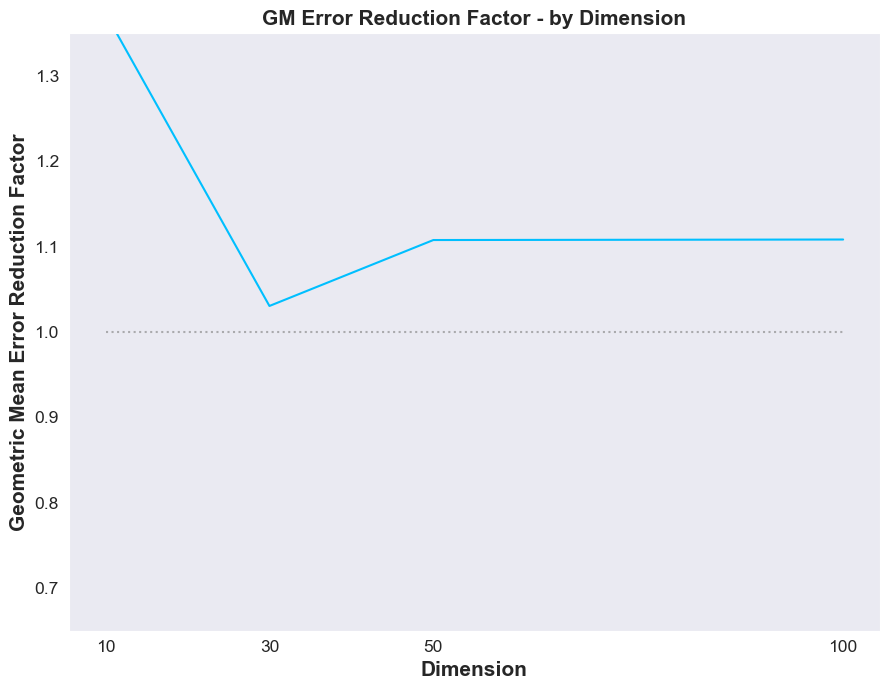


Overall Runtime Improvement Factor (Geometric Mean of sobol_Time / hds_Time): 0.9509
Overall Runtime (Paired Wilcoxon Signed-Rank Test):
    - W-stat: 3586687.00, p-value: 5.64e-292

Runtime improvement factor by dimension:
   Dimensions  Run_Time_Ratio  Runtime_p_Value
0          10        0.955518     3.680482e-12
1          30        0.963639     9.871099e-52
2          50        0.958043     6.664946e-87
3         100        0.927062    9.913916e-171


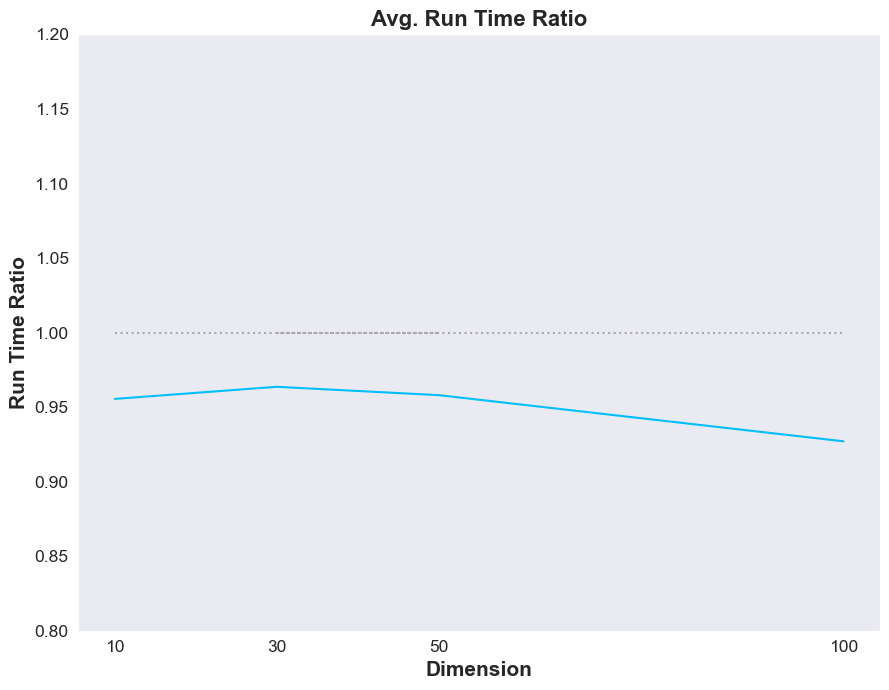

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gmean
import re

sns.set_style('dark')

epsilon = 1e-12

def cec2017_optimum(function_name):
    '''
    Returns the known optimum value (f*) for a CEC2017 function with F{func_ID}2017 format.
    '''
    match = re.search(r'F(\d+)2017', function_name)
    
    if match:
        func_id = int(match.group(1))
        # CEC2017 functions F1 to F30 have optimums f* = ID * 100
        if 1 <= func_id <= 30:
            return float(func_id * 100)
    return 0.0

def calculate_geometric_mean_ratio(df_group):
    '''Calculates the Geometric Mean of the Improvement_Ratio for a group.'''
    # drop nulls before g-mean
    gmean_ratio = gmean(df_group['Improvement_Ratio'].dropna())
    return gmean_ratio

def wilcoxon_paired_error(df_group):
    '''Calculates the p-value from a paired Wilcoxon test for Error_Value_sobol vs Error_Value_hds.'''
    # compares paired error columns (delta f)
    wilcoxon_statistic, p_value = stats.wilcoxon(
        df_group['Error_Value_sobol'], 
        df_group['Error_Value_hds']
        ) 
    return p_value

def wilcoxon_paired_runtime(df_group):
    '''
    Calculates the p-value from a paired Wilcoxon test for Error_Value_sobol vs Error_Value_hds.
    '''
    # compares paired error columns (delta f)
    wilcoxon_statistic, p_value = stats.wilcoxon(
        df_group['Run_Time_Sec_sobol'], 
        df_group['Run_Time_Sec_hds']
        ) 
    return p_value

def calculate_geometric_mean_error(series):
    '''
    Calculates the geometric mean error of the series.
    '''
    positive_series = series.clip(lower=epsilon)
    return gmean(positive_series)

def iqr_error(series):
    '''
    Calculates the (IQR) of the error series as a string.
    '''
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    return f'({Q1:.2e}, {Q3:.2e})' 

def calculate_gmean_ci(df_group, confidence=0.95):
    '''
    Calculates 95% confidence interval for the geometric mean of 'Improvement_Ratio', 
    using a log-transformation and t.interval. Returns a pandas Series with the CI bounds.
    '''
    
    # log-transform the ratios
    log_ratios = np.log(df_group['Improvement_Ratio'].dropna())
    
    # calculate the sample statistics of the log-transformed data
    n = len(log_ratios)
    if n < 2:
        # null for insufficient data volume
        return pd.Series([np.nan, np.nan], index=['CI_Lower', 'CI_Upper']) 
        
    mean_log = np.mean(log_ratios)
    # ddof=1 for sample standard deviation
    std_log = np.std(log_ratios, ddof=1) 
    
    # calculate the confidence interval for the mean of the log-transformed data
    std_err = std_log / np.sqrt(n)
    ci_log = stats.t.interval(confidence, n - 1, loc=mean_log, scale=std_err)
    
    # exponentiate the confidence interval bounds to get the CI for the geometric mean
    ci_lower = np.exp(ci_log[0])
    ci_upper = np.exp(ci_log[1])
    
    # return the results as a named Series
    final_ci = pd.Series([ci_lower, ci_upper], index=['CI_Lower', 'CI_Upper'])

    return final_ci

t_df = pd.read_csv('sampling_cec_results_hyperellipsoid_final.csv')
t_df.dropna(how='any', axis=0, inplace=True)
print(f'Number of trials: {t_df['trial_num'].nunique()}')
print(f'Number of data points: {len(t_df)}')

# calculate the true optimum (f*) for each row
t_df['True_Optimum'] = t_df['Function'].apply(cec2017_optimum)

# calculate the error (delta f)
t_df['Error_Value'] = t_df['Fitness_Value'] - t_df['True_Optimum']

sobol_df = t_df[t_df['Method'] == 'Sobol']
hds_df = t_df[t_df['Method'] == 'HDS']

# merge dataframes
merged_df = pd.merge(
    hds_df, 
    sobol_df, 
    on=['Function', 'Dimensions', 'True_Optimum', 'trial_num'],
    suffixes=('_hds', '_sobol')
    )

# calculate improvement ratios
merged_df['Capped_Error_hds'] = merged_df['Error_Value_hds'].clip(lower=epsilon) # ensure positive for gmean
merged_df['Capped_Error_sobol'] = merged_df['Error_Value_sobol'].clip(lower=epsilon) # ensure positive for gmean
merged_df['Improvement_Ratio'] = merged_df['Capped_Error_sobol'] / merged_df['Capped_Error_hds']

# geometric mean ratio and p-value
avg_ratio_by_dimensions_error = merged_df.groupby(['Dimensions']).apply(calculate_geometric_mean_ratio).reset_index(name='Improvement_Ratio')
p_values_df = merged_df.groupby('Dimensions').apply(wilcoxon_paired_error).reset_index(name='p_Value')
final_stats_df = pd.merge(avg_ratio_by_dimensions_error, p_values_df, on='Dimensions')

# geometric mean and IQR for HDS
hds_gm_df = merged_df.groupby('Dimensions')['Capped_Error_hds'].apply(calculate_geometric_mean_error).reset_index(name='GM_hds_Error')
hds_iqr_df = merged_df.groupby('Dimensions')['Error_Value_hds'].apply(iqr_error).reset_index(name='IQR_hds_Error')

# geometric mean for sobol
sobol_gm_df = merged_df.groupby('Dimensions')['Capped_Error_sobol'].apply(calculate_geometric_mean_error).reset_index(name='GM_sobol_Error')

# merge to final dataframe
final_stats_df = pd.merge(final_stats_df, hds_gm_df, on='Dimensions')
final_stats_df = pd.merge(final_stats_df, hds_iqr_df, on='Dimensions')
final_stats_df = pd.merge(final_stats_df, sobol_gm_df, on='Dimensions')

# create final dataframe
final_stats_df = final_stats_df[[
    'Dimensions',
    'GM_hds_Error', 
    'IQR_hds_Error', 
    'GM_sobol_Error', 
    'Improvement_Ratio', 
    'p_Value'
    ]]

# overall geometric mean
geometric_mean_ratio = gmean(merged_df['Improvement_Ratio'].dropna())
print(f'\nGeometric Mean error reduction factor (sobol_error / hds_error): {geometric_mean_ratio:.4e}')

# overall Wilcoxon test
wilcoxon_statistic, p_value = stats.wilcoxon(merged_df['Error_Value_sobol'], merged_df['Error_Value_hds'])
print(f'Overall Error (Paired Wilcoxon Signed-Rank Test):\n    - W-stat: {wilcoxon_statistic:.2f}\n    - p-value: {p_value:.2e}')

# apply geometric mean
avg_ratio_by_dimensions_error = merged_df.groupby(['Dimensions']).apply(calculate_geometric_mean_ratio).reset_index(name='Improvement_Ratio')
    
# apply CI calculation
gmean_ci_df = merged_df.groupby('Dimensions').apply(calculate_gmean_ci).reset_index()

# merge the CI with final statistics dataframe
final_stats_df = pd.merge(final_stats_df, gmean_ci_df, on='Dimensions')

print('\nStatistical Analysis by Dimension:')
print(final_stats_df)
final_stats_df.to_csv('results/statistical_analysis_by_dimensions.csv', index=False)

# plot for error reduction vs. dimensions
plt.figure(figsize=(9,7))
sns.lineplot(data=avg_ratio_by_dimensions_error,x='Dimensions',y='Improvement_Ratio',color='deepskyblue')
plt.plot([10,100], [1,1],linestyle=':',color='gray',alpha=0.6)
plt.title('GM Error Reduction Factor - by Dimension',fontsize=15,fontweight='bold')
plt.xlabel('Dimension',fontsize=15,fontweight='bold')
plt.ylabel('Geometric Mean Error Reduction Factor',fontsize=15,fontweight='bold') 
plt.xticks(sorted(merged_df['Dimensions'].unique()),fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.ylim(0.65,1.35)

plt.tight_layout()
plt.savefig('results/improvement_vs_dimensions.png')
plt.show()

# runtime analysis
merged_df['Run_Time_Ratio'] = merged_df['Run_Time_Sec_sobol'] / merged_df['Run_Time_Sec_hds']

# calculate average runtime ratio by dim
avg_ratio_by_dim = merged_df.groupby(['Dimensions'])['Run_Time_Ratio'].apply(gmean).reset_index(name='Run_Time_Ratio')

# calculate the runtime p-value by dim
runtime_p_values_df = merged_df.groupby('Dimensions').apply(wilcoxon_paired_runtime).reset_index(name='Runtime_p_Value')

# merge the p-values into the runtime ratio dataframe
avg_ratio_by_dim = pd.merge(avg_ratio_by_dim, runtime_p_values_df, on='Dimensions')

# overall runtime improvement
overall_runtime_improvement_factor = gmean(merged_df['Run_Time_Ratio'])
wilcoxon_statistic, p_value = stats.wilcoxon(merged_df['Run_Time_Sec_sobol'], merged_df['Run_Time_Sec_hds'])
print(f'\nOverall Runtime Improvement Factor (Geometric Mean of sobol_Time / hds_Time): {overall_runtime_improvement_factor:.4f}')
print(f'Overall Runtime (Paired Wilcoxon Signed-Rank Test):\n    - W-stat: {wilcoxon_statistic:.2f}, p-value: {p_value:.2e}')
print('\nRuntime improvement factor by dimension:')
print(avg_ratio_by_dim)

# save to csv
avg_ratio_by_dim.to_csv('results/runtime_dimensions.csv', index=False)

# plot for runtime ratio vs. dimensions
plt.figure(figsize=(9,7))
sns.lineplot(data=avg_ratio_by_dim,x='Dimensions',y='Run_Time_Ratio',color='deepskyblue')
plt.plot(merged_df['Dimensions'].unique(), [1,]*len(merged_df['Dimensions'].unique()),linestyle=':',color='gray',alpha=0.6)
plt.title('Avg. Run Time Ratio',fontsize=16,fontweight='bold')
plt.xlabel('Dimension',fontsize=15,fontweight='bold')
plt.ylabel('Run Time Ratio',fontsize=15,fontweight='bold') 
plt.xticks(sorted(merged_df['Dimensions'].unique()),fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.ylim(0.8,1.2)

plt.tight_layout()
plt.savefig('results/runtime_vs_dimensions.png')
plt.show()

In [34]:
final_stats_df.columns

Index(['Dimensions', 'GM_hds_Error', 'IQR_hds_Error', 'GM_sobol_Error',
       'Improvement_Ratio', 'p_Value', 'CI_Lower', 'CI_Upper'],
      dtype='object')

## Discrepancy Analysis

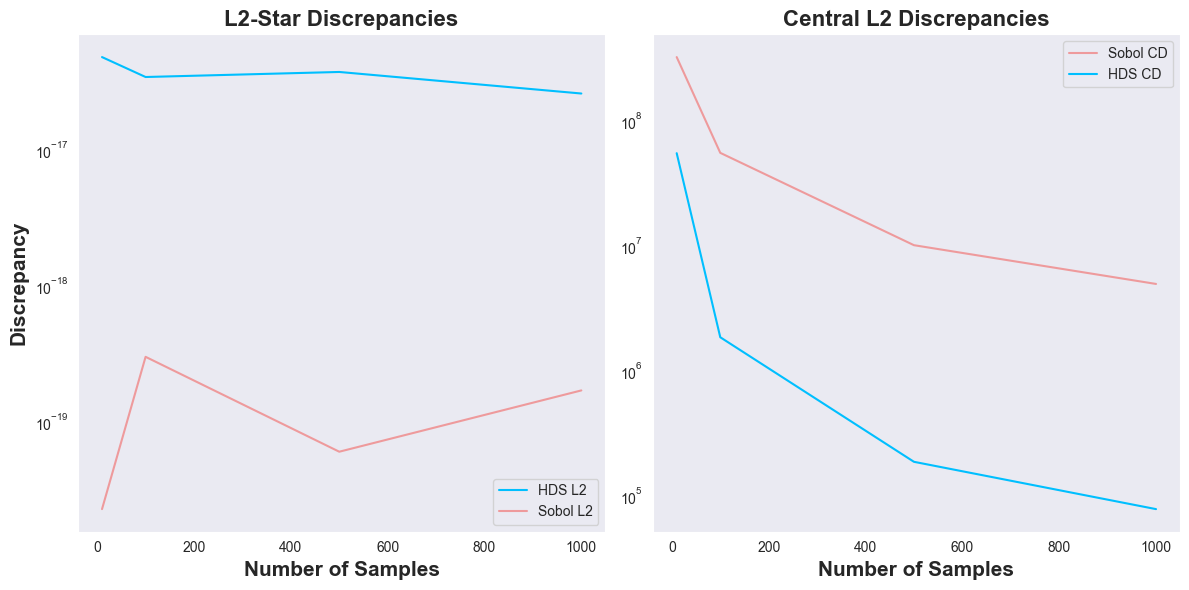

In [28]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style('dark')

# n_dimensions = 100
# bounds = [(-100, 100)] * int(n_dimensions)
# sample_list = [10, 100, 500, 1_000]
# n_trials = 30

# print('Generating and comparing samples.')
# discrepancy_data = []
# for n_samples in sample_list:
#     print(f'    - samples: {n_samples}')

#     # comparison sobol sequence
#     sobol_sampler = stats.qmc.Sobol(d=n_dimensions)
#     sobol_samples_unit = sobol_sampler.random(n=n_samples)
#     sobol_L2 = stats.qmc.discrepancy(sobol_samples_unit, iterative=False, method='L2-star')
#     sobol_Star = stats.qmc.discrepancy(sobol_samples_unit, iterative=False, method='CD')
    
#     # hds sequence
#     for i in range(0, n_trials):
#         hds_samples_unit = sample(n_samples, np.array(bounds), normalize=True, seed=None)
        
#         # discrepancies
#         hds_L2 = stats.qmc.discrepancy(hds_samples_unit, iterative=False, method='L2-star')
#         hds_Star = stats.qmc.discrepancy(hds_samples_unit, iterative=False, method='CD')
        
#         # store results
#         discrepancy_data.append({
#             'n_samples':n_samples,
#             'L2_discrepancy': hds_L2,
#             'Star_discrepancy': hds_Star,
#             'Sobol_L2_Benchmark': sobol_L2,
#             'Sobol_Star_Benchmark': sobol_Star,
#              })

# # full dataframe
# discrepancy_df = pd.DataFrame(discrepancy_data)

# def analyze_discrepancy(group_df, discrepancy_type):
#     '''
#     Calculates mean, stdev, 95% CI, and p-value (vs. Sobol) for the given discrepancy metric.
#     '''

#     hds_times = group_df[f'{discrepancy_type}_discrepancy']
#     n = len(hds_times)
    
#     # fixed sobol discrepancy for each group
#     sobol_benchmark = group_df[f'Sobol_{discrepancy_type}_Benchmark'].iloc[0]
    
#     mean_hds = hds_times.mean()
#     std_hds = hds_times.std()
    
#     # one-sample T-Test:  mean(HDS) = Sobol Benchmark
#     t_stat, p_value = stats.ttest_1samp(a=hds_times, popmean=sobol_benchmark)

#     # calculate 95% CI for hds mean
#     sem = std_hds / np.sqrt(n) # standard error of the mean
    
#     # calculate T-distribution interval
#     if sem == 0 or n <= 1:
#         ci_lower, ci_upper = mean_hds, mean_hds
#     else:
#         ci_lower, ci_upper = stats.t.interval(
#             confidence=0.95,
#             df=n - 1,
#             loc=mean_hds,
#             scale=sem
#             )

#     # reformat to strings
#     ci_string = f"({ci_lower:.1e}, {ci_upper:.1e})"
#     p_value_str = f"{p_value:.1e}" if not pd.isna(p_value) else 'NaN'

#     # return series for result
#     return pd.Series({
#         f'Sobol_{discrepancy_type}': sobol_benchmark,
#         f'HDS_{discrepancy_type}': mean_hds,
#         f'CI_95_HDS_{discrepancy_type}': ci_string,
#         f'P_Value_{discrepancy_type}': p_value_str
#        })

# # L2 discrepancy
# l2_results = discrepancy_df.groupby('n_samples').apply(lambda x: analyze_discrepancy(x, 'L2')).reset_index()

# # centered L2 discrepancy
# star_results = discrepancy_df.groupby('n_samples').apply(lambda x: analyze_discrepancy(x, 'Star')).reset_index()

# # merge results into single df
# final_discrepancy_df = pd.merge(l2_results, star_results, on='n_samples').set_index('n_samples')

# print('\n   - Discrepancy Analysis (HDS vs Sobol)')
# pd.set_option('display.max_columns', None)
# display(final_discrepancy_df)

# # reset options
# pd.reset_option('display.max_columns')
# pd.reset_option('display.float_format')

# # save data
# final_discrepancy_df.to_csv('results/disrepancies.csv')

# # load data
final_discrepancy_df = pd.read_csv('results/disrepancies.csv')

# plot
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(final_discrepancy_df['n_samples'], final_discrepancy_df['HDS_L2'], linestyle='-', 
            color='deepskyblue', label='HDS L2')
axs[0].plot(final_discrepancy_df['n_samples'], final_discrepancy_df['Sobol_L2'], linestyle='-', 
            color='lightcoral', label='Sobol L2', alpha=0.75)

axs[1].plot(final_discrepancy_df['n_samples'], final_discrepancy_df['Sobol_Star'], linestyle='-', 
            color='lightcoral', label='Sobol CD', alpha=0.75)
axs[1].plot(final_discrepancy_df['n_samples'], final_discrepancy_df['HDS_Star'], linestyle='-', 
            color='deepskyblue', label='HDS CD')

axs[0].set_title('L2-Star Discrepancies', fontweight='bold', fontsize=16)
axs[0].set_xlabel('Number of Samples', fontweight='bold', fontsize=15)
axs[0].set_ylabel('Discrepancy', fontweight='bold', fontsize=15)
axs[0].set_yscale('log')

axs[1].set_title('Central L2 Discrepancies', fontweight='bold', fontsize=16)
axs[1].set_xlabel('Number of Samples', fontweight='bold', fontsize=15)
axs[1].set_ylabel('')
axs[1].set_yscale('log')

axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.savefig('results/discrepancies.png')
plt.show()

## Sample Generation Time Analysis

Generating samples.
    - Trial 0
    - Trial 1
    - Trial 2
    - Trial 3
    - Trial 4
    - Trial 5
    - Trial 6
    - Trial 7
    - Trial 8
    - Trial 9
    - Trial 10
    - Trial 11
    - Trial 12
    - Trial 13
    - Trial 14
    - Trial 15
    - Trial 16
    - Trial 17
    - Trial 18
    - Trial 19
    - Trial 20
    - Trial 21
    - Trial 22
    - Trial 23
    - Trial 24
    - Trial 25
    - Trial 26
    - Trial 27
    - Trial 28
    - Trial 29
    - Trial 30
    - Trial 31
    - Trial 32
    - Trial 33
    - Trial 34
    - Trial 35
    - Trial 36
    - Trial 37
    - Trial 38
    - Trial 39
    - Trial 40
    - Trial 41
    - Trial 42
    - Trial 43
    - Trial 44
    - Trial 45
    - Trial 46
    - Trial 47
    - Trial 48
    - Trial 49

     - Statistical Summary


,average_generation_time_sec,std_dev_generation_time_sec,ci_95
n_samples,,,
10,1.587936,0.447541,"(1.461, 1.715)"
100,1.400275,0.236419,"(1.333, 1.467)"
500,1.424305,0.190775,"(1.370, 1.479)"
1000,1.456347,0.199953,"(1.400, 1.513)"
5000,1.567301,0.279897,"(1.488, 1.647)"
10000,1.699022,0.273931,"(1.621, 1.777)"
100000,2.544460,0.290259,"(2.462, 2.627)"
1000000,11.949212,0.911435,"(11.690, 12.208)"


Saved to csv.


,average_generation_time_sec,std_dev_generation_time_sec,ci_95
n_samples,,,
10,1.587936,0.447541,"(1.461, 1.715)"
100,1.400275,0.236419,"(1.333, 1.467)"
500,1.424305,0.190775,"(1.370, 1.479)"
1000,1.456347,0.199953,"(1.400, 1.513)"
5000,1.567301,0.279897,"(1.488, 1.647)"
10000,1.699022,0.273931,"(1.621, 1.777)"
100000,2.544460,0.290259,"(2.462, 2.627)"
1000000,11.949212,0.911435,"(11.690, 12.208)"


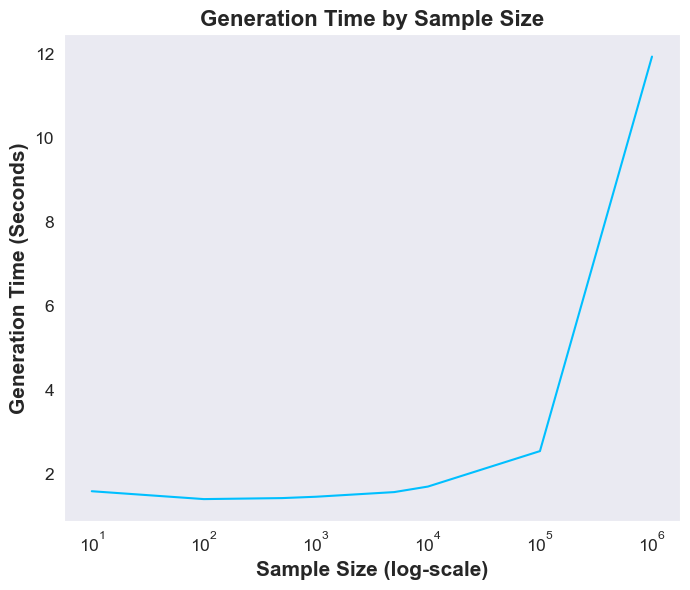

In [29]:
import seaborn as sns
sns.set_style('dark')

# # sample parameters
# n_dimensions = 100
# bounds = [(-100, 100)] * int(n_dimensions)

# sample_list = [10,100,500,1_000,5_000,10_000,100_000,1_000_000]
# dimension_list = [1,10,50,100,1000]
# n_trials = 50

# # store timing
# timing_data = []

# # run sampling algorithm and time it
# print('Generating samples.')
# for i in range(0, n_trials):
#     print(f'    - Trial {i}')
#     for n_samples in sample_list:
#         start_time = time.time() 
#         current_samples = sample(n_samples, bounds)
        
#         end_time = time.time()
#         generation_time = end_time - start_time
        
#         timing_data.append({
#             'n_samples': n_samples, 
#             'generation_time': generation_time,
#             'index': i
#         })

# # full dataframe from all trials
# timing_df = pd.DataFrame(timing_data)

# def analyze_generation_time(group_df):
#     '''
#     Runs statistical analysis of sample generation time (mean, stdev, 95% CI).
#     '''

#     times = group_df['generation_time']
#     n = len(times)
    
#     # mean and stdev
#     mean_time = times.mean()
#     std_time = times.std()
    
#     # calculate 95% CI for the mean
#     sem = std_time / np.sqrt(n) # standard error of the mean
    
#     # calculate T-distribution interval
#     # if n <= 1, CI collapses is the mean
#     if sem == 0 or n <= 1:
#         ci_lower, ci_upper = mean_time, mean_time
#     else:
#         ci_lower, ci_upper = stats.t.interval(
#             confidence=0.95,
#             df=n - 1,          
#             loc=mean_time,     
#             scale=sem          
#             )
        
#     # reformat
#     ci_lower_str = f"{ci_lower:.3f}"
#     ci_upper_str = f"{ci_upper:.3f}"
#     ci_string = f"({ci_lower_str}, {ci_upper_str})"

#     # return series of results
#     return pd.Series({
#         'average_generation_time_sec': mean_time,
#         'std_dev_generation_time_sec': std_time,
#         'ci_95': ci_string
#         })

# # apply analysis function
# average_time_df = timing_df.groupby('n_samples').apply(analyze_generation_time)

# print('\n     - Statistical Summary')

# # reformat
# pd.set_option('display.float_format', '{:.6f}'.format)
# display(average_time_df)

# # # save to csv
# average_time_df.to_csv('results/generation_times_samples.csv')
# print('Saved to csv.')

# read csv
average_time_df = pd.read_csv('results/generation_times_samples.csv',index_col='n_samples')
display(average_time_df)

# plot
plt.figure(figsize=(7,6))

plt.plot(average_time_df['average_generation_time_sec'],color='deepskyblue')
plt.title('Generation Time by Sample Size', fontweight='bold',fontsize=16)
plt.ylabel('Generation Time (Seconds)', fontweight='bold',fontsize=15)
plt.xlabel('Sample Size (log-scale)', fontweight='bold',fontsize=15)
plt.xscale('log')
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)

plt.tight_layout()
plt.savefig('results/generation_times_samples.png')
plt.show()

### By Dimensions

Generating samples.
    - Trial 0
    - Trial 1
    - Trial 2
    - Trial 3
    - Trial 4
    - Trial 5
    - Trial 6
    - Trial 7
    - Trial 8
    - Trial 9
    - Trial 10
    - Trial 11
    - Trial 12
    - Trial 13
    - Trial 14
    - Trial 15
    - Trial 16
    - Trial 17
    - Trial 18
    - Trial 19
    - Trial 20
    - Trial 21
    - Trial 22
    - Trial 23
    - Trial 24
    - Trial 25
    - Trial 26
    - Trial 27
    - Trial 28
    - Trial 29
    - Trial 30
    - Trial 31
    - Trial 32
    - Trial 33
    - Trial 34
    - Trial 35
    - Trial 36
    - Trial 37
    - Trial 38
    - Trial 39
    - Trial 40
    - Trial 41
    - Trial 42
    - Trial 43
    - Trial 44
    - Trial 45
    - Trial 46
    - Trial 47
    - Trial 48
    - Trial 49

     - Statistical Summary


,average_generation_time_sec,std_dev_generation_time_sec,ci_95
dimensions,,,
1,0.165964,0.034407,"(0.156, 0.176)"
10,0.357799,0.126311,"(0.322, 0.394)"
50,1.117602,0.212665,"(1.057, 1.178)"
100,1.667001,0.297539,"(1.582, 1.752)"
1000,6.826345,0.601077,"(6.656, 6.997)"


Saved to csv.


,average_generation_time_sec,std_dev_generation_time_sec,ci_95
dimensions,,,
1,0.165964,0.034407,"(0.156, 0.176)"
10,0.357799,0.126311,"(0.322, 0.394)"
50,1.117602,0.212665,"(1.057, 1.178)"
100,1.667001,0.297539,"(1.582, 1.752)"
1000,6.826345,0.601077,"(6.656, 6.997)"


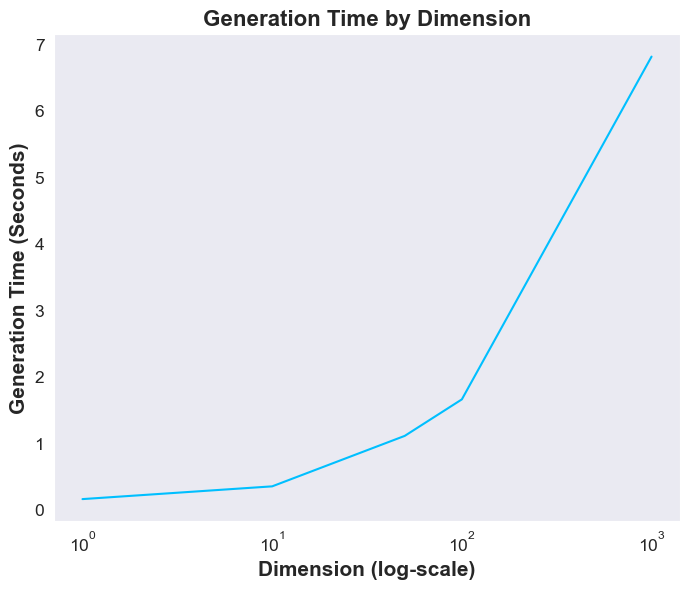

In [30]:
sns.set_style('dark')

# # sample parameters
# sample_list = [10,100,500,1_000,5_000,10_000]
# dimension_list = [1,10,50,100,1000]
# n_trials = 50

# # store timing
# timing_data = []

# # run sampling algorithm and time it
# print('Generating samples.')
# for i in range(0, n_trials):
#     print(f'    - Trial {i}')
#     for dimension in dimension_list:
#         bounds = [(-100, 100)] * int(dimension)
        
#         start_time = time.time()
#         current_samples = sample(1000, bounds)
        
#         end_time = time.time()
#         generation_time = end_time - start_time
        
#         timing_data.append({
#             'dimensions': dimension, 
#             'generation_time': generation_time,
#             'index': i
#             })

# # full dataframe from all trials
# timing_df = pd.DataFrame(timing_data)

# def analyze_generation_time(group_df):
#     '''
#     Performs full statistical analysis of sample generation time (mean, stdev, 95% CI).
#     '''

#     times = group_df['generation_time']
#     n = len(times)
    
#     # mean and stdev
#     mean_time = times.mean()
#     std_time = times.std()
    
#     # calculate 95% CI for the mean
#     sem = std_time / np.sqrt(n) # standard error of the mean
    
#     # calculate T-distribution interval
#     # if n <= 1, CI collapses is the mean
#     if sem == 0 or n <= 1:
#         ci_lower, ci_upper = mean_time, mean_time
#     else:
#         ci_lower, ci_upper = stats.t.interval(
#             confidence=0.95,
#             df=n - 1,          
#             loc=mean_time,     
#             scale=sem          
#            )
        
#     # reformat
#     ci_lower_str = f"{ci_lower:.3f}"
#     ci_upper_str = f"{ci_upper:.3f}"
#     ci_string = f"({ci_lower_str}, {ci_upper_str})"

#     # return series of results
#     return pd.Series({
#         'average_generation_time_sec': mean_time,
#         'std_dev_generation_time_sec': std_time,
#         'ci_95': ci_string
#        })

# # apply analysis function
# average_time_df = timing_df.groupby('dimensions').apply(analyze_generation_time)

# print('\n     - Statistical Summary')

# # reformat
# pd.set_option('display.float_format', '{:.6f}'.format)
# display(average_time_df)

# # save to csv
# average_time_df.to_csv('results/generation_times_dimensions.csv')
# print('Saved to csv.')

# read csv
average_time_df = pd.read_csv('results/generation_times_dimensions.csv',index_col='dimensions')
display(average_time_df)

# plot
plt.figure(figsize=(7,6))

plt.plot(average_time_df['average_generation_time_sec'],color='deepskyblue')
plt.title('Generation Time by Dimension', fontweight='bold',fontsize=16)
plt.ylabel('Generation Time (Seconds)', fontweight='bold',fontsize=15)
plt.xlabel('Dimension (log-scale)', fontweight='bold',fontsize=15)
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)
plt.xscale('log')

plt.tight_layout()
plt.savefig('results/generation_times_dimensions.png')
plt.show()

### Combining Plots

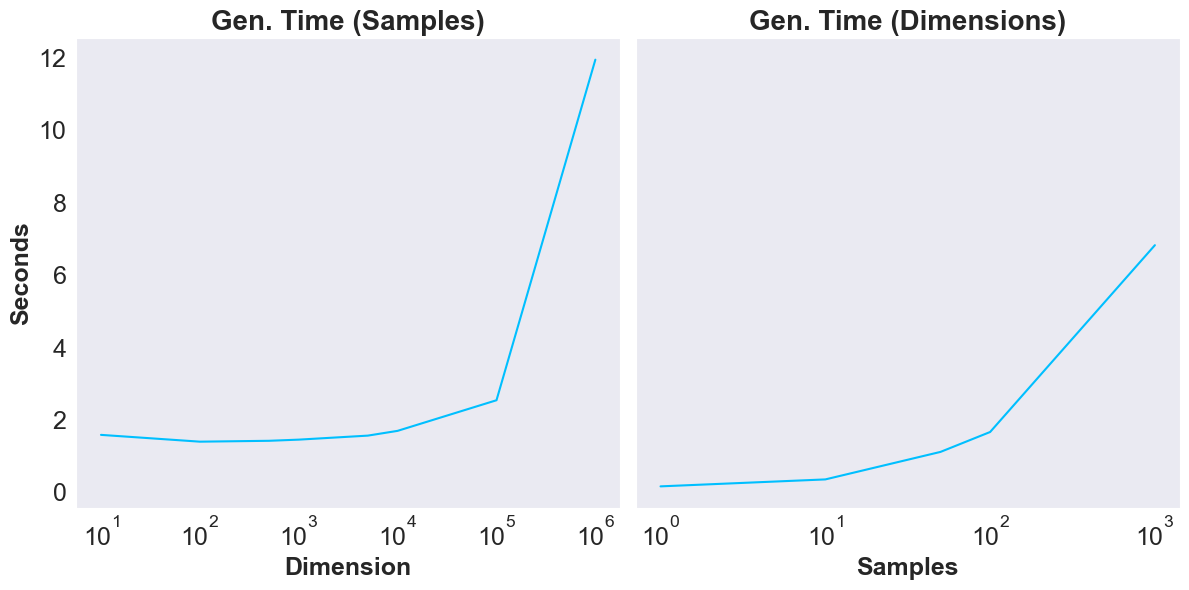

In [12]:
# combining plots
# read csv
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

sns.set_style('dark')
average_time_samples_df = pd.read_csv('results/generation_times_samples.csv',index_col='n_samples')


# read csv
average_time_dimensions_df = pd.read_csv('results/generation_times_dimensions.csv',index_col='dimensions')

# plot
fig, ax = plt.subplots(1,2,figsize=(12,6),sharey=True)

ax[0].plot(average_time_samples_df['average_generation_time_sec'],color='deepskyblue')
ax[0].set_title('Gen. Time (Samples)', fontweight='bold',fontsize=20)
ax[0].set_ylabel('Seconds', fontweight='bold',fontsize=18)
ax[0].set_xlabel('Dimension', fontweight='bold',fontsize=18)
# ax[0].set_xticks(fontsize=12.5)
# ax[0].set_yticks(fontsize=12.5)
ax[0].set_xscale('log')
ax[0].tick_params(axis='x', labelsize=18)
ax[0].tick_params(axis='y', labelsize=18)


ax[1].plot(average_time_dimensions_df['average_generation_time_sec'],color='deepskyblue')
ax[1].set_title('Gen. Time (Dimensions)', fontweight='bold',fontsize=20)
ax[1].set_ylabel('')
ax[1].set_xlabel('Samples', fontweight='bold',fontsize=18)
ax[1].set_xscale('log')
ax[1].tick_params(axis='x', labelsize=18)
ax[1].tick_params(axis='y', labelsize=18)
# ax[1].set_xticks(fontsize=12.5)
# ax[1].set_yticks(fontsize=12.5)

plt.tight_layout()
plt.savefig('results/generation_times_final.png')
plt.show()